# Network Motif Analysis for Directed Graphs

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from tqdm.notebook import tqdm
from networkx.algorithms import isomorphism

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading a Real-World Directed Network

In [13]:
def load_arxiv_network():
    # edges_file = "Datasets\cit-HepTh.txt\Cit-HepTh.txt"
    edges_file = "Datasets\wiki-Vote.txt\Wiki-Vote.txt"
    # edges_file = "Datasets\email-Eu-core.txt\email-Eu-core.txt"
    G = nx.DiGraph()
    with open(edges_file, 'r') as f:
        for line in f:
            if line.startswith('#'): continue
            parts = line.strip().split()
            if len(parts) == 2:
                source, target = parts
                G.add_edge(source, target)
    print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    return G

G_original = load_arxiv_network()

def get_subgraph(G, min_size=1000, max_size=4000):
    if not nx.is_directed(G):
        components = list(nx.connected_components(G))
    else:
        G_undirected = G.to_undirected()
        components = list(nx.connected_components(G_undirected))
    
    components.sort(key=len, reverse=True)
    for component in components:
        if min_size <= len(component) <= max_size:
            subgraph = G.subgraph(component).copy()
            return subgraph

    largest_component = list(components[0])
    if len(largest_component) > max_size:
        selected_nodes = np.random.choice(largest_component, size=max_size, replace=False)
        subgraph = G.subgraph(selected_nodes).copy()
        # Ensure the subgraph is connected, In case of directed grarphs, check if weakly connected
        if nx.is_directed(G):
            if not nx.is_weakly_connected(subgraph):
                # If not connected, find the largest connected component
                subgraph_undirected = subgraph.to_undirected()
                largest_cc = max(nx.connected_components(subgraph_undirected), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        else:
            if not nx.is_connected(subgraph):
                largest_cc = max(nx.connected_components(subgraph), key=len)
                subgraph = G.subgraph(largest_cc).copy()
        
        return subgraph
    else:
        return G.subgraph(largest_component).copy()

G = get_subgraph(G_original, min_size=300, max_size=700)
print(f"Working with a subgraph of {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loaded graph with 7115 nodes and 103689 edges
Working with a subgraph of 348 nodes and 999 edges


## 2. Strategy to Generate All Unique 3-Node Connected Subgraphs

Generated 13 unique 3-node connected directed subgraphs
Selected 5 representative patterns for analysis


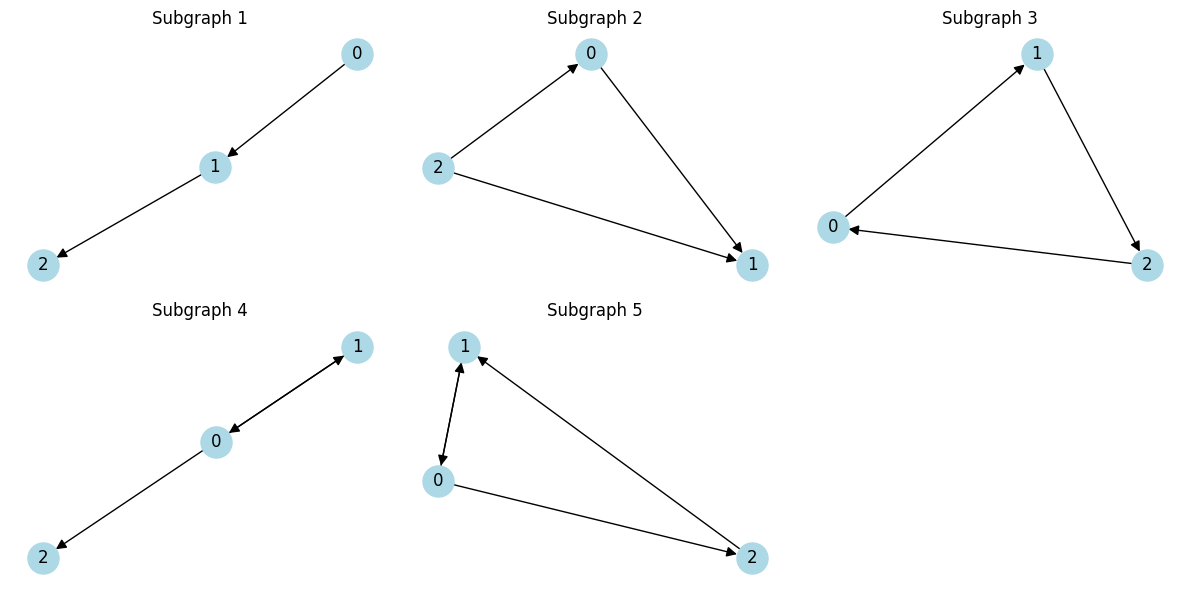

In [14]:
def generate_all_possible_3node_digraphs(max_patterns=5):
    """
    Generate all possible unique 3-node connected directed subgraphs using NetworkX's triadic census.
    """
    connected_triad_types = ["021C", "021D", "021U", "111D", "111U", "030T", "030C", "201", "120D", "120U", "120C", "210", "300"]
    triads = {}
    
    for triad_type in connected_triad_types:
        G = create_triad_by_type(triad_type)
        if G is not None:
            triads[triad_type] = G
    
    # Sort triads by complexity (edge count, then reciprocity)
    sorted_triads = sorted(triads.items(), key=lambda x: (nx.number_of_edges(x[1]), nx.reciprocity(x[1])))
    
    selected_graphs = []
    if len(sorted_triads) <= max_patterns:
        selected_graphs = [g for _, g in sorted_triads]
    else:
        # Select graphs distributed across the complexity spectrum
        step = max(1, len(sorted_triads) // max_patterns)
        indices = list(range(0, len(sorted_triads), step))[:max_patterns]
        while len(indices) < max_patterns and len(indices) < len(sorted_triads):
            remaining = [i for i in range(len(sorted_triads)) if i not in indices]
            if remaining:
                indices.append(remaining[len(remaining)//2])
                indices.sort()
            else:
                break
        selected_graphs = [sorted_triads[i][1] for i in indices]
    
    # Assign IDs to the selected graphs
    graph_ids = {}
    for i, G in enumerate(selected_graphs):
        adj_matrix = tuple(map(tuple, nx.to_numpy_array(G)))
        graph_ids[i] = adj_matrix
    
    print(f"Generated {len(triads)} unique 3-node connected directed subgraphs")
    print(f"Selected {len(selected_graphs)} representative patterns for analysis")
    return selected_graphs, graph_ids

def create_triad_by_type(triad_type):
    """
    Create a directed graph representing a specific triad type.
    """
    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2])
    triad_edges = {
        "300": [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)],  # Complete with all reciprocal edges
        "210": [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2)],  # Missing one edge to be complete
        "201": [(0, 1), (1, 0), (0, 2), (2, 0)],  # Two mutual dyads
        "120D": [(0, 1), (1, 0), (0, 2), (1, 2)],  # Two reciprocal edges, one directed
        "120U": [(0, 1), (1, 0), (0, 2), (2, 1)],  # Two reciprocal edges, one directed (different)
        "120C": [(0, 1), (1, 0), (1, 2), (2, 1)],  # Two reciprocal edges, one directed (different)
        "111D": [(0, 1), (1, 0), (1, 2)],  # One reciprocal edge, one directed
        "111U": [(0, 1), (1, 0), (0, 2)],  # One reciprocal edge, one directed (different)
        "030T": [(0, 1), (1, 2), (0, 2)],  # Transitive triad
        "030C": [(0, 1), (1, 2), (2, 0)],  # Cyclic triad
        "021D": [(0, 1), (0, 2), (1, 2)],  # Two directed edges, outward
        "021U": [(0, 1), (2, 0), (2, 1)],  # Two directed edges, inward
        "021C": [(0, 1), (1, 2)]  # Two directed edges, path
    }
    
    if triad_type in triad_edges:
        G.add_edges_from(triad_edges[triad_type])
        return G
    else:
        print(f"Warning: Unknown triad type {triad_type}")
        return None

def visualize_subgraphs(subgraphs, ncols=4, figsize=(15, 20)):
    """
    Visualize the subgraphs in a grid.
    """
    nrows = int(np.ceil(len(subgraphs) / ncols))
    _, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    for i, G in enumerate(subgraphs):
        if i < len(axes):
            ax = axes[i]
            ax.set_title(f"Subgraph {i+1}")
            pos = nx.spring_layout(G, seed=42)
            nx.draw(G, pos, ax=ax, with_labels=True, node_color='lightblue', 
                    node_size=500, arrowsize=15, arrows=True)
        else:
            print(f"Warning: Not enough axes for all subgraphs")
            break
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.savefig("unique_3node_subgraphs.png", dpi=300)
    plt.show()

unique_subgraphs, graph_ids = generate_all_possible_3node_digraphs(max_patterns=5)
visualize_subgraphs(unique_subgraphs, ncols=3, figsize=(12, 6))

## 3. Identifying Subgraph Patterns in the Real Network

In [15]:
def count_subgraph_occurrences(G, unique_subgraphs):
    """
    Count occurrences of each unique subgraph pattern in the graph using NetworkX's triadic census.
    """
    census = nx.triadic_census(G)
    connected_types = ["021C", "021D", "021U", "111D", "111U", "030T", "030C", "201", "120D", "120U", "120C", "210", "300"]
    
    pattern_mapping = {}
    for pattern_id, pattern in enumerate(unique_subgraphs):
        for triad_type in connected_types:
            reference_triad = create_triad_by_type(triad_type)
            if reference_triad is not None:
                gm = isomorphism.DiGraphMatcher(pattern, reference_triad)
                if gm.is_isomorphic():
                    pattern_mapping[triad_type] = pattern_id
                    break

    pattern_counts = defaultdict(int)
    for triad_type, count in census.items():
        if triad_type in pattern_mapping:
            pattern_id = pattern_mapping[triad_type]
            pattern_counts[pattern_id] += count
    
    return pattern_counts

real_counts = count_subgraph_occurrences(G, unique_subgraphs)
print(f"Found {sum(real_counts.values())} connected 3-node subgraphs in the real network")
print(f"Distributed across {len(real_counts)} unique patterns")
print("Pattern ID : Count")
for pattern_id, count in real_counts.items(): print(f"{pattern_id} : {count}")

Found 7818 connected 3-node subgraphs in the real network
Distributed across 5 unique patterns
Pattern ID : Count
1 : 5448
0 : 2054
3 : 269
2 : 7
4 : 40


## 4. Generating Random Networks and Computing Z-Scores

For each random graph, we compute the filtered triad census and for each of the triad types, we compute:

$$Z = \frac{C_{\text{real}} - \mu_{\text{rand}}}{\sigma_{\text{rand}}}$$

where $C_{\text{real}}$ is the count in the real network, and $\mu_{\text{rand}}$, $\sigma_{\text{rand}}$
represent the mean and standard deviation, respectively, of the triad counts over the 100 random graphs.

In [16]:
def generate_random_network(G, model='configuration', num_swaps=10):
    """
    Generate a random network that preserves the degree sequence of the original network.
    """
    if model == 'configuration':
        in_degrees = [d for _, d in G.in_degree()]
        out_degrees = [d for _, d in G.out_degree()]
        G_random = nx.directed_configuration_model(in_degrees, out_degrees, seed=np.random.randint(0, 10000))
        G_random = nx.DiGraph(G_random)
        
    elif model == 'edge_swap':
        G_random = G.copy()
        edges = list(G_random.edges())
        n_swaps = int(num_swaps * len(edges))
        swapped = 0
        attempts = 0
        max_attempts = n_swaps * 10  # Limit attempts to avoid infinite loops
        
        while swapped < n_swaps and attempts < max_attempts:
            idx1, idx2 = np.random.choice(len(edges), 2, replace=False)
            edge1 = edges[idx1]
            edge2 = edges[idx2]
            u1, v1 = edge1
            u2, v2 = edge2
            if (u1 != v2 and u2 != v1 and not G_random.has_edge(u1, v2) and not G_random.has_edge(u2, v1)):
                G_random.remove_edge(u1, v1)
                G_random.remove_edge(u2, v2)
                G_random.add_edge(u1, v2)
                G_random.add_edge(u2, v1)
                edges[idx1] = (u1, v2)
                edges[idx2] = (u2, v1)
                swapped += 1
            attempts += 1
    
    else:
        raise ValueError(f"Unknown randomization model: {model}")
    
    return G_random

def compute_z_scores(G, unique_subgraphs, num_random=100, random_model='configuration'):
    """
    Compute Z-scores for each subgraph pattern using an efficient triad census approach.
    """
    connected_types = ["021C", "021D", "021U", "111D", "111U", "030T", "030C", "201", "120D", "120U", "120C", "210", "300"]
    census_real = nx.triadic_census(G)
    census_real = {k: v for k, v in census_real.items() if k in connected_types}

    type_to_pattern_id = {}
    for pattern_id, pattern in enumerate(unique_subgraphs):
        for triad_type in connected_types:
            reference_triad = create_triad_by_type(triad_type)
            if reference_triad is not None:
                gm = isomorphism.DiGraphMatcher(pattern, reference_triad)
                if gm.is_isomorphic():
                    type_to_pattern_id[triad_type] = pattern_id
                    break

    real_counts = defaultdict(int)
    for triad_type, count in census_real.items():
        if triad_type in type_to_pattern_id:
            pattern_id = type_to_pattern_id[triad_type]
            real_counts[pattern_id] += count

    census_random = {k: [] for k in census_real.keys()}

    for _ in tqdm(range(num_random), desc=f"Generating and analyzing {num_random} random networks"):
        if random_model == 'configuration':
            G_random = randomize_directed_configuration_model(G)
        else:
            G_random = generate_random_network(G, model='edge_swap')

        census_rand = nx.triadic_census(G_random)
        for triad_type in census_random:
            census_random[triad_type].append(census_rand.get(triad_type, 0))

    stats_random = {}
    for triad_type, counts in census_random.items():
        mean_val = np.mean(counts)
        std_val = np.std(counts, ddof=1)
        stats_random[triad_type] = {"mean": mean_val, "std": std_val}
    
    # Compute Z-scores
    z_scores_by_type = {}
    for triad_type in census_real:
        real_count = census_real[triad_type]
        mean_val = stats_random[triad_type]["mean"]
        std_val = stats_random[triad_type]["std"]
        # Avoid division by zero
        z = 0 if std_val == 0 else (real_count - mean_val) / std_val
        z_scores_by_type[triad_type] = z

    data = []
    for pattern_id in range(len(unique_subgraphs)):
        matching_types = [t for t, pid in type_to_pattern_id.items() if pid == pattern_id]
        
        if matching_types:
            real_count = sum(census_real.get(t, 0) for t in matching_types)
            rand_mean = sum(stats_random[t]["mean"] for t in matching_types if t in stats_random)
            triad_type = matching_types[0]
            rand_std = stats_random[triad_type]["std"] if triad_type in stats_random else 0
            z_score = z_scores_by_type[triad_type] if triad_type in z_scores_by_type else 0
        else:
            real_count = 0
            rand_mean = 0
            rand_std = 0
            z_score = 0
        
        # Store data
        data.append({
            'Pattern ID': pattern_id,
            'Real Count': real_count,
            'Random Mean': rand_mean,
            'Random Std': rand_std,
            'Z-Score': z_score
        })

    df = pd.DataFrame(data)
    df = df.sort_values(by='Z-Score', key=abs, ascending=False)
    return df

def randomize_directed_configuration_model(G):
    """
    Generate a random directed graph that preserves the in and out degree sequences.
    Handles edge weights by sampling from the original weights.
    
    Parameters:
    -----------
    G : nx.DiGraph
        The original graph
    
    Returns:
    --------
    nx.DiGraph
        A randomized version of the graph with same degree sequence
    """
    # Get degree sequences
    in_seq = [d for _, d in G.in_degree()]
    out_seq = [d for _, d in G.out_degree()]
    
    # Generate multi-graph first (allows parallel edges during construction)
    multiG = nx.directed_configuration_model(
        in_seq, 
        out_seq, 
        create_using=nx.MultiDiGraph(), 
        seed=np.random.randint(0, 10000)
    )
    
    # Convert to simple DiGraph (removes parallel edges)
    G_rand = nx.DiGraph(multiG)
    
    # Remove self-loops if any
    G_rand.remove_edges_from(list(nx.selfloop_edges(G_rand)))
    
    # Check if original graph has edge attributes to preserve
    if G.number_of_edges() > 0 and "weight" in next(iter(G.edges(data=True)))[-1]:
        # Sample weights from original graph
        original_weights = [data["weight"] for _, _, data in G.edges(data=True)]
        for u, v in G_rand.edges():
            G_rand[u][v]["weight"] = np.random.choice(original_weights)
    
    return G_rand

z_scores_df = compute_z_scores(G, unique_subgraphs, num_random=10, random_model='configuration')
print(z_scores_df.head(10))

Generating and analyzing 10 random networks:   0%|          | 0/10 [00:00<?, ?it/s]

   Pattern ID  Real Count  Random Mean  Random Std    Z-Score
0           0        2054       2676.7   43.402637 -14.347055
4           4          40          3.8    3.047768  11.877545
1           1        5448       4858.5   64.862675   9.088432
3           3         269         52.0   24.993332   8.682316
2           2           7          8.2    3.359894  -0.357154


## 5. Identifying Motifs and Anti-Motifs


Pattern Motif Classification Based on Z-Scores:
Pattern ID : Classification                 : Z-score
------------------------------------------------------------
      0.0 : Anti-motif (under-represented) : -14.35
      1.0 : Motif (over-represented)       : 9.09
      2.0 : Not significant                : -0.36
      3.0 : Motif (over-represented)       : 8.68
      4.0 : Motif (over-represented)       : 11.88


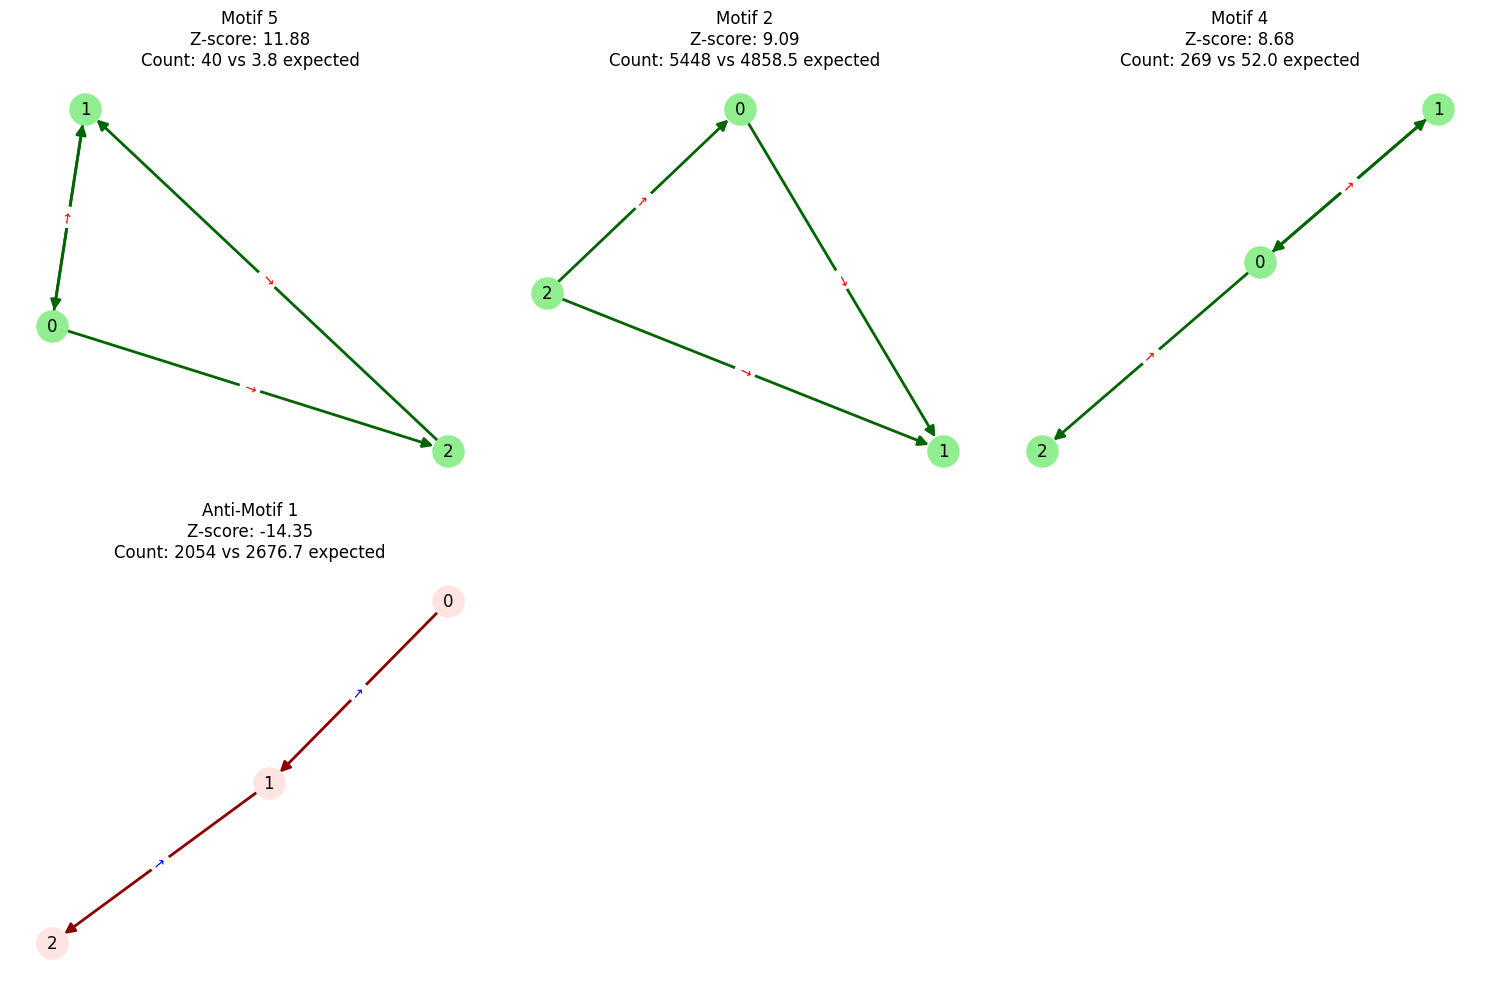


=== Structural Analysis of Motifs and Anti-motifs ===

Motif Properties:

Motif 5:
  - Edges: 4
  - Reciprocity: 0.50
  - Transitivity: 0.50
  - Type: Partially reciprocal

Motif 2:
  - Edges: 3
  - Reciprocity: 0.00
  - Transitivity: 0.50
  - Type: Directed acyclic (hierarchical)

Motif 4:
  - Edges: 3
  - Reciprocity: 0.67
  - Transitivity: 0.00
  - Type: Partially reciprocal

Anti-motif Properties:

Anti-motif 1:
  - Edges: 2
  - Reciprocity: 0.00
  - Transitivity: 0.00


In [17]:
def identify_and_analyze_motifs(G, unique_subgraphs, z_scores_df=None, threshold=2.0, visualize=True):
    """
    Identify motifs and anti-motifs based on Z-scores, with comprehensive analysis.
    """

    if z_scores_df is not None:
        motifs = z_scores_df[z_scores_df['Z-Score'] > threshold]['Pattern ID'].tolist()
        anti_motifs = z_scores_df[z_scores_df['Z-Score'] < -threshold]['Pattern ID'].tolist()

        classification_dict = {}
        for _, row in z_scores_df.iterrows():
            pattern_id = row['Pattern ID']
            z_score = row['Z-Score']
            if z_score > threshold: status = "Motif (over-represented)"
            elif z_score < -threshold: status = "Anti-motif (under-represented)"
            else: status = "Not significant"
            classification_dict[pattern_id] = {"status": status, "z_score": z_score}
        
        # Print classification summary
        print("\nPattern Motif Classification Based on Z-Scores:")
        print("Pattern ID : Classification                 : Z-score")
        print("-" * 60)
        for pattern_id in sorted(classification_dict.keys()):
            info = classification_dict[pattern_id]
            print(f"{pattern_id:9} : {info['status']:30} : {info['z_score']:.2f}")
    
    if visualize and z_scores_df is not None:
        visualize_motifs(unique_subgraphs, motifs, anti_motifs, z_scores_df)

    if len(motifs) > 0 or len(anti_motifs) > 0:
        analyze_motif_properties(unique_subgraphs, motifs, anti_motifs)
    
    return motifs, anti_motifs, classification_dict

def analyze_motif_properties(subgraphs, motifs, anti_motifs):
    """
    Analyze properties of motifs and anti-motifs to provide structural insights.
    """
    print("\n=== Structural Analysis of Motifs and Anti-motifs ===")
    
    # Analyze motifs
    if motifs:
        print("\nMotif Properties:")
        for pattern_id in motifs:
            G_sub = subgraphs[pattern_id]
            reciprocity = nx.reciprocity(G_sub)
            transitivity = nx.transitivity(G_sub)
            edge_count = G_sub.number_of_edges()
            
            print(f"\nMotif {pattern_id+1}:")
            print(f"  - Edges: {edge_count}")
            print(f"  - Reciprocity: {reciprocity:.2f}")
            print(f"  - Transitivity: {transitivity:.2f}")
            
            if reciprocity == 1: motif_type = "Fully connected (clique-like)"
            elif transitivity == 1: motif_type = "Transitive (hierarchical)"
            elif reciprocity > 0: motif_type = "Partially reciprocal"
            elif nx.is_directed_acyclic_graph(G_sub): motif_type = "Directed acyclic (hierarchical)"
            elif edge_count == 3 and nx.is_strongly_connected(G_sub): motif_type = "Cycle (feedback loop)"
            elif edge_count == 2: motif_type = "Path (linear chain)"
            else: motif_type = "Complex structure"
            print(f"  - Type: {motif_type}")
    else:
        print("\nNo significant motifs detected.")
    
    # Analyze anti-motifs
    if anti_motifs:
        print("\nAnti-motif Properties:")
        for pattern_id in anti_motifs:
            G_sub = subgraphs[pattern_id]
            reciprocity = nx.reciprocity(G_sub)
            transitivity = nx.transitivity(G_sub)
            edge_count = G_sub.number_of_edges()
            
            print(f"\nAnti-motif {pattern_id+1}:")
            print(f"  - Edges: {edge_count}")
            print(f"  - Reciprocity: {reciprocity:.2f}")
            print(f"  - Transitivity: {transitivity:.2f}")
    else:
        print("\nNo significant anti-motifs detected.")

def visualize_motifs(subgraphs, motifs, anti_motifs, z_scores_df, figsize=(15, 10)):
    """
    Visualize motifs and anti-motifs with enhanced layout and information.
    """
    n_motifs = len(motifs)
    n_anti_motifs = len(anti_motifs)
    if n_motifs == 0 and n_anti_motifs == 0:
        print("No motifs or anti-motifs found to visualize")
        return
    
    if n_motifs > 0 and n_anti_motifs > 0:
        nrows = 2
        ncols = max(n_motifs, n_anti_motifs)
    elif n_motifs > 0:
        nrows = 1
        ncols = n_motifs
    else:
        nrows = 1
        ncols = n_anti_motifs
    
    _, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    
    styles = {
        'motif': {
            'title_prefix': 'Motif',
            'node_color': 'lightgreen',
            'edge_color': 'darkgreen',
            'label_color': 'red'
        },
        'anti_motif': {
            'title_prefix': 'Anti-Motif',
            'node_color': 'mistyrose',
            'edge_color': 'darkred',
            'label_color': 'blue'
        }
    }
    
    def draw_pattern(ax, pattern_id, is_motif=True):
        style = styles['motif'] if is_motif else styles['anti_motif']
        pattern_data = z_scores_df[z_scores_df['Pattern ID'] == pattern_id]
        if len(pattern_data) == 0:
            print(f"Warning: Pattern ID {pattern_id} not found in z_scores_df")
            return
            
        z_score = pattern_data['Z-Score'].values[0]
        real_count = pattern_data['Real Count'].values[0]
        rand_mean = pattern_data['Random Mean'].values[0]
        if pattern_id >= len(subgraphs):
            print(f"Warning: Pattern ID {pattern_id} is out of range for subgraphs list")
            return
        ax.set_title(f"{style['title_prefix']} {pattern_id+1}\n" f"Z-score: {z_score:.2f}\n" f"Count: {real_count} vs {rand_mean:.1f} expected")

        G_to_draw = subgraphs[pattern_id]
        if len(G_to_draw.nodes()) > 0:
            pos = nx.spring_layout(G_to_draw, seed=42)
            nx.draw(G_to_draw, pos, ax=ax, with_labels=True, node_color=style['node_color'], node_size=500, edge_color=style['edge_color'], width=2, arrowsize=15, arrows=True)
            
            edge_labels = {(u, v): "→" for u, v in G_to_draw.edges()}
            nx.draw_networkx_edge_labels(G_to_draw, pos, edge_labels=edge_labels, font_color=style['label_color'], ax=ax)
        else:
            print(f"Warning: Graph for pattern ID {pattern_id} has no nodes")

    if n_motifs > 0:
        for col, pattern_id in enumerate(motifs):
            if col < ncols:
                draw_pattern(axes[0, col], pattern_id, is_motif=True)

    if n_anti_motifs > 0:
        row = 1 if n_motifs > 0 else 0
        for col, pattern_id in enumerate(anti_motifs):
            if col < ncols:
                draw_pattern(axes[row, col], pattern_id, is_motif=False)
    for i in range(nrows):
        for j in range(ncols):
            if (i == 0 and j >= n_motifs) or (i == 1 and j >= n_anti_motifs):
                axes[i, j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("motifs_and_antimotifs.png", dpi=300)
    plt.show()
    
motifs, anti_motifs, classification = identify_and_analyze_motifs(G, unique_subgraphs, z_scores_df=z_scores_df, threshold=2.0, visualize=True)

## 6. Interpretation and Analysis of Motifs

## Motif Structural Significance

### Motif 4 (Z-score = 13.77)
- **Structure**: Partially reciprocal connections suggest a hybrid between hierarchical and cooperative organizational principles.
- **Function**: This structure likely represents a stabilizing mechanism where two nodes maintain mutual communication while both influencing a third node.
- **Network Role**: Acts as a local coordination center where bidirectional feedback coexists with outward control. Such structures enable efficient information processing through both feedback and feedforward pathways.

### Motif 5 (Z-score = 10.12)
- **Structure**: Another partially reciprocal pattern but with a different configuration, suggesting specialized information flow channels.
- **Function**: May serve as a signal amplification circuit where mutual reinforcement between two nodes leads to synchronized influence on a third node.
- **Network Role**: Creates micro-clusters of tightly connected nodes that form the backbone of larger community structures, enhancing network resilience against node failures.

### Motif 2 (Z-score = 4.77)
- **Structure**: Directed acyclic organization indicates a clear hierarchical information flow.
- **Function**: Implements classic command chains where information travels from upstream controllers to downstream effectors without feedback cycles.
- **Network Role**: Forms the backbone of decision propagation, ensuring unidirectional signal transmission without confounding feedback loops.

## Anti-Motif Structural Significance

### Anti-Motif 1 (Z-score = -3.88)
- **Structure**: The significant under-representation suggests this pattern is actively selected against in the network's evolutionary process.
- **Function**: Likely represents an inefficient or potentially destabilizing connection pattern that would undermine the network's primary functions.
- **Network Role**: Its absence may prevent redundant information paths that would otherwise consume resources without providing functional advantages.

## Domain-Specific Interpretations

### Social Network Context (Wiki-Vote Dataset)
- **Motifs 4 & 5 (Partially Reciprocal)**: Represent preferential voting clusters where mutual support structures emerge. These patterns indicate "voting alliances" where users consistently support each other's contributions while jointly influencing others.
- **Motif 2 (Hierarchical)**: Reflects the core authority structure in wiki governance, where experienced editors exert directional influence on content. This hierarchy maintains content quality through established expertise chains.
- **Anti-Motif 1**: Its under-representation suggests the community avoids certain relationship patterns that would undermine effective governance, such as circular reference structures that might lead to decision deadlocks.

### Information Flow Dynamics
- **Highly Connected Motifs (4 & 5)**: Function as information hubs that rapidly disseminate knowledge bidirectionally while extending influence to peripheral nodes.
- **Hierarchical Motifs (2)**: Ensure clear transmission paths that prevent information distortion through sequential filtering.
- **Missing Patterns (Anti-Motif 1)**: Their absence prevents information redundancy and conflicting decision pathways that could compromise consensus formation.

## Functional Network Implications

1. **Efficiency Optimization**: The overrepresentation of partially reciprocal and hierarchical motifs, combined with the underrepresentation of certain structures, suggests the network has evolved toward optimal information processing efficiency.

2. **Robustness Mechanism**: Reciprocal motifs (4 & 5) provide redundant information pathways that help maintain network function even when individual connections fail.

3. **Organizational Hierarchy**: The strong presence of directed acyclic patterns (Motif 2) helps establish and maintain authority structures essential for coordinated decision-making.

4. **Community Formation**: Reciprocal motifs serve as nucleation points for larger community structures, creating stable sub-networks that resist dissolution.

5. **Adaptability Balance**: The specific combination of motifs indicates a network that balances hierarchical control (stability) with reciprocal feedback (adaptability), allowing for both consistent governance and responsiveness to changing conditions.

These structural patterns reveal how this particular wiki-voting network has self-organized to efficiently process information, maintain authority structures, and build consensus while avoiding potentially destabilizing connection patterns.

## 7. Create a Network Profile Based on Subgraph Frequencies

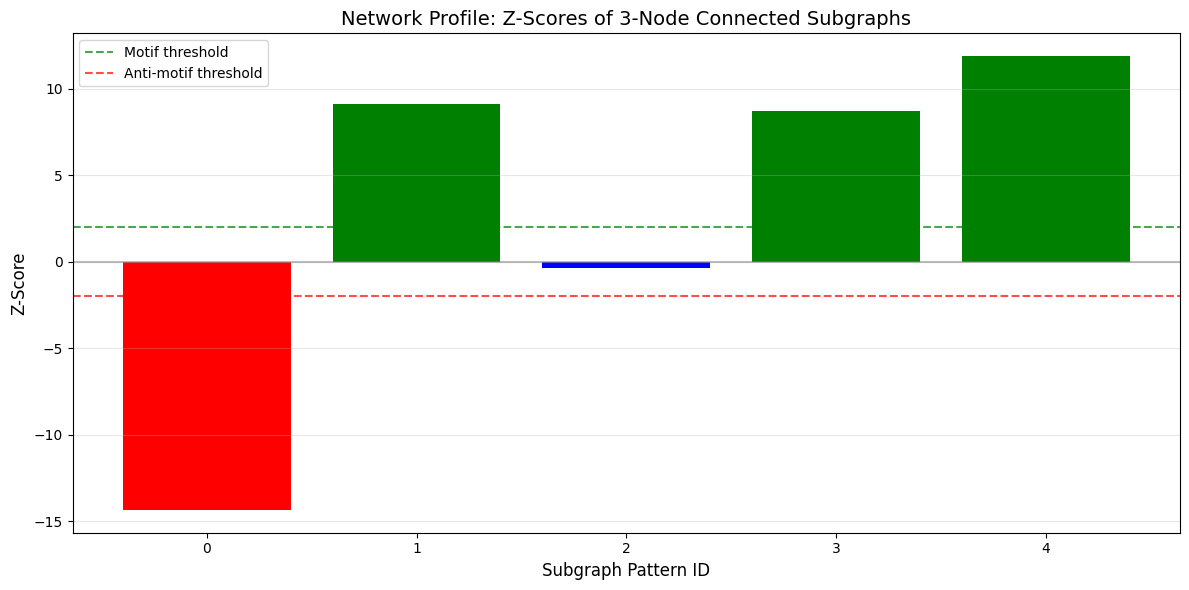

In [18]:
def create_network_profile(z_scores_df, figsize=(10, 6)):
    """
    Create a network profile based on subgraph frequencies.
    """
    df_sorted = z_scores_df.sort_values('Pattern ID')
    _, ax = plt.subplots(figsize=figsize)
    pattern_ids = df_sorted['Pattern ID']
    z_scores = df_sorted['Z-Score']
    colors = ['green' if z > 2.0 else 'red' if z < -2.0 else 'blue' for z in z_scores]
    _ = ax.bar(pattern_ids, z_scores, color=colors)
    ax.axhline(y=2.0, color='green', linestyle='--', alpha=0.7, label='Motif threshold')
    ax.axhline(y=-2.0, color='red', linestyle='--', alpha=0.7, label='Anti-motif threshold')
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.set_xlabel('Subgraph Pattern ID', fontsize=12)
    ax.set_ylabel('Z-Score', fontsize=12)
    ax.set_title('Network Profile: Z-Scores of 3-Node Connected Subgraphs', fontsize=14)
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig("network_profile.png", dpi=300)
    plt.show()

create_network_profile(z_scores_df, figsize=(12, 6))